Running VGG-like Dynamic Pruning with 97% Sparsity (350 epochs)...


100%|██████████| 170M/170M [00:04<00:00, 42.1MB/s]


Epoch: 1/350 | Train Loss: 4.0742, Train Acc: 10.09% | Val Loss: 2.3043, Val Acc: 9.84% | Sparsity: 0.006
Epoch: 26/350 | Train Loss: 1.4055, Train Acc: 61.96% | Val Loss: 1.4269, Val Acc: 58.51% | Sparsity: 0.168
Epoch: 51/350 | Train Loss: 1.2077, Train Acc: 71.47% | Val Loss: 1.2538, Val Acc: 68.51% | Sparsity: 0.330
Epoch: 76/350 | Train Loss: 1.1472, Train Acc: 73.84% | Val Loss: 1.2728, Val Acc: 67.71% | Sparsity: 0.491
Epoch: 101/350 | Train Loss: 1.1087, Train Acc: 75.49% | Val Loss: 1.2233, Val Acc: 68.55% | Sparsity: 0.653
Epoch: 126/350 | Train Loss: 1.0484, Train Acc: 77.60% | Val Loss: 1.2152, Val Acc: 69.71% | Sparsity: 0.815
Epoch: 151/350 | Train Loss: 0.9640, Train Acc: 81.34% | Val Loss: 1.0330, Val Acc: 77.18% | Sparsity: 0.970
Epoch: 176/350 | Train Loss: 0.9368, Train Acc: 82.14% | Val Loss: 1.0791, Val Acc: 75.40% | Sparsity: 0.970
Epoch: 201/350 | Train Loss: 0.9049, Train Acc: 83.50% | Val Loss: 0.9456, Val Acc: 80.69% | Sparsity: 0.970
Epoch: 226/350 | Train Lo

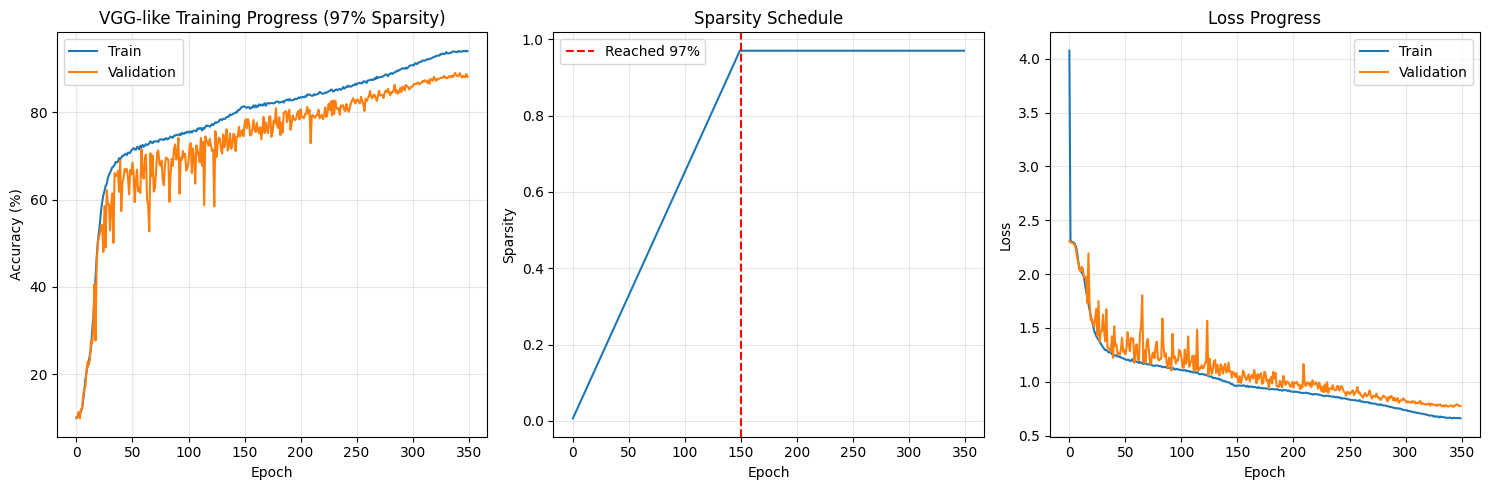

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

PDF downloaded successfully


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import time
import matplotlib.pyplot as plt

# Define VGG-like (smaller than VGG19) with mask application
class DynamicSparseVGGLike(nn.Module):
    def __init__(self, num_classes=10):
        super(DynamicSparseVGGLike, self).__init__()
        self.masks = {}  # Store masks for each layer

        # VGG-like configuration (smaller than VGG19)
        cfg = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']

        self.features = self._make_layers(cfg)

        # Classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
        )

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                          nn.BatchNorm2d(x),
                          nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

    def apply_masks(self):
        """Apply masks to weights during forward pass"""
        if not hasattr(self, 'masks') or not self.masks:
            return
        with torch.no_grad():
            for name, param in self.named_parameters():
                mask = self.masks.get(name, None)
                if mask is not None:
                    param.mul_(mask)

    def forward(self, x):
        # Apply masks before forward pass
        self.apply_masks()

        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

def VGGLike(num_classes=10):
    return DynamicSparseVGGLike(num_classes=num_classes)

def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.ones_(m.weight)
            nn.init.zeros_(m.bias)

def apply_dynamic_supermask(model, sparsity_rate):
    """Fixed implementation with no regrowth - once pruned, stays pruned"""
    total_params = 0
    active_mags = []
    metas = []  # (name, param, current_mask)

    # Gather active weights only
    for name, param in model.named_parameters():
        if ('weight' in name) and (param.dim() > 1):
            current_mask = getattr(model, 'masks', {}).get(name, torch.ones_like(param, device=param.device))
            mags = param.detach().abs()
            active_vals = mags[current_mask.bool()]  # Only active entries
            active_mags.append(active_vals)
            metas.append((name, param, current_mask))
            total_params += param.numel()

    if not active_mags:
        return {}, 0.0

    active_cat = torch.cat(active_mags)
    # How many weights should remain nonzero globally at this sparsity
    keep_target = int(round((1.0 - sparsity_rate) * total_params))
    # Clamp to current active count
    keep_k = min(keep_target, active_cat.numel())

    if keep_k <= 0:
        thr = active_cat.max() + 1  # Prune all currently active
    else:
        thr = torch.topk(active_cat, keep_k, largest=True, sorted=True)[0][-1]

    # Build new masks with NO REGROWTH
    masks = {}
    pruned_params = 0
    for name, param, current_mask in metas:
        mags = param.detach().abs()
        new_keep = (mags >= thr).float()
        final_mask = new_keep * current_mask  # Intersect: forbids regrowth
        masks[name] = final_mask
        pruned_params += (final_mask == 0).sum().item()

    actual_sparsity = pruned_params / total_params

    # Store masks in model
    if not hasattr(model, 'masks'):
        model.masks = {}
    model.masks.update(masks)

    return masks, actual_sparsity

def train_with_dynamic_pruning(model, train_loader, val_loader, test_loader, epochs=350, device='cuda', seed=42):
    """Extended training: reach 97% sparsity by epoch 150, then continue at 97% for 200 more epochs"""
    torch.manual_seed(seed)
    np.random.seed(seed)

    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4
    )
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    initial_sparsity = 0.0
    final_sparsity = 0.97  # 97% sparsity for VGG-like
    pruning_epochs = 150  # Reach 97% by epoch 150

    train_losses = []
    val_losses = []
    train_acc = []
    val_acc = []
    sparsity_history = []

    initialize_weights(model)

    # Track training time
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        correct = 0
        total = 0

        # Dynamic sparsity schedule: reach 97% by epoch 150, stay at 97% afterwards
        if epoch < pruning_epochs:
            current_sparsity = initial_sparsity + (final_sparsity - initial_sparsity) * ((epoch + 1) / pruning_epochs)
        else:
            current_sparsity = final_sparsity

        masks, actual_sparsity = apply_dynamic_supermask(model, current_sparsity)
        sparsity_history.append(actual_sparsity)

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()

            # Apply masks to gradients
            for name, param in model.named_parameters():
                if name in masks and param.grad is not None:
                    param.grad.mul_(masks[name])

            optimizer.step()

            # Re-enforce masks post-step
            with torch.no_grad():
                for name, param in model.named_parameters():
                    mask = model.masks.get(name, None)
                    if mask is not None:
                        param.mul_(mask)

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / total
        train_accuracy = 100.0 * correct / total

        # Validation
        val_loss, val_accuracy = evaluate(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_acc.append(train_accuracy)
        val_acc.append(val_accuracy)

        scheduler.step()

        if epoch % 25 == 0 or epoch == epochs - 1:
            print(
                f"Epoch: {epoch+1}/{epochs} | "
                f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}% | "
                f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}% | "
                f"Sparsity: {actual_sparsity:.3f}"
            )

    training_time = time.time() - start_time

    # Final evaluation
    test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)

    results = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_acc': train_acc,
        'val_acc': val_acc,
        'test_loss': test_loss,
        'test_accuracy': test_accuracy,
        'sparsity_history': sparsity_history,
        'training_time': training_time,
        'final_sparsity': actual_sparsity
    }

    return results

def evaluate(model, data_loader, criterion, device):
    model.eval()
    loss_total = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            loss_total += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    avg_loss = loss_total / total
    accuracy = 100.0 * correct / total
    return avg_loss, accuracy

if __name__ == "__main__":
    print("Running VGG-like Dynamic Pruning with 97% Sparsity (350 epochs)...")

    # Set seed
    seed = 42
    torch.manual_seed(seed)
    np.random.seed(seed)

    # Data setup
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.RandomErasing(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    ])

    train_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform_train
    )
    test_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=transform_test
    )

    train_size = int(0.89 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_subset, val_subset = torch.utils.data.random_split(
        train_dataset, [train_size, val_size]
    )

    train_loader = torch.utils.data.DataLoader(
        train_subset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True
    )
    val_loader = torch.utils.data.DataLoader(
        val_subset, batch_size=128, shuffle=False, num_workers=4, pin_memory=True
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=128, shuffle=False, num_workers=4, pin_memory=True
    )

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = VGGLike(num_classes=10).to(device)

    # Train with extended epochs
    results = train_with_dynamic_pruning(
        model, train_loader, val_loader, test_loader, epochs=350, device=device, seed=seed
    )

    print(f"\n=== Final Results ===")
    print(f"Test Accuracy: {results['test_accuracy']:.2f}%")
    print(f"Final Sparsity: {results['final_sparsity']:.3f}")
    print(f"Training Time: {results['training_time']:.1f}s")

    # Plot results
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(results['train_acc'], label='Train')
    plt.plot(results['val_acc'], label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('VGG-like Training Progress (97% Sparsity)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 3, 2)
    plt.plot(results['sparsity_history'])
    plt.axvline(x=150, color='r', linestyle='--', label='Reached 97%')
    plt.xlabel('Epoch')
    plt.ylabel('Sparsity')
    plt.title('Sparsity Schedule')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 3, 3)
    plt.plot(results['train_losses'], label='Train')
    plt.plot(results['val_losses'], label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Progress')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()

    # Save as PDF
    plt.savefig('vgglike_97_sparsity_350epochs.pdf', format='pdf', bbox_inches='tight', dpi=300)
    print("Plot saved as vgglike_97_sparsity_350epochs.pdf")
    plt.show()

    # Download in Colab
    try:
        from google.colab import files
        files.download('vgglike_97_sparsity_350epochs.pdf')
        print("PDF downloaded successfully")
    except ImportError:
        print("Not running in Colab - PDF saved locally")